A primer for working with the **_Sp_**atial **_Int_**eraction modeling (SpInt) module in the python spatial analysis library (PySAL)
===================================================================================================================


## Introduction

Spatial interaction modeling involves the analysis of flows from an origin to a destination either over physical space (i.e., migration) or through abstract space (i.e., telecommunication). Despite being a fundamental technique to many geogaphic disciplines, there is relatively little software available to carry out spatial interaction modeling and the analysis of flow data. Therefore, the purpose of this primer is to provide an overview of the recently develped spatial interaction modeling (SpInt) module of the python spatial analysis library (PySAL). First, the current framework of the module will be highlighted. Next, the main functionality of the module will be illustrated with a common regional science example, migration flows, with a dataset previously used for spatial interaction modeling tutorials in the R programming environment. Finally, some auxilliary functionality and future additions are discussed. 


## The SpInt Framework

### Modeling framework

The core purpose of the SpInt module is to provide the functionality to calibrate spatial interaction models. Since the "family" of spatial interaction models put forth by Wilson (Wilson, 1971) are perhaps the most popular, they were chosen as the starting point of the module. Consider the basic gravity model (Fotheringham & O'Kelly, 1989), 

$$T_{ij} = k\frac{V_{i}^\mu W_{j}^\alpha}{d_{ij}^\beta} \quad(1)$$


where 

- $T_{ij}$ = an $n \times m$ matrix of flows between $n$ origins (subscripted by $i$) to $m$ destinations (subscripted by $j$) 


- $V$ = an $n \times p$ and vector of $p$ origin attributes describing the emissiveness of $i$ 


- $W$ = an $m \times p$ vector of $p$ destination attributes describing the attractiveness of $j$ 


- $d$ = an $n \times m$ matrix of the costs to overcome the physical separation between  $i$ and $j$ (usually distance or time) 


- $k$ = a scaling factor to be estimated to ensure the total flows is consistent 


- $\mu$ = a $p \times 1$ vector of parameters representing the effect of $p$ origin attributes on flows 


- $\alpha$ = a $p \times 1$ vector of parameters representing the effect of $p$ destination attributes on flows 


- $\beta$ = an exponential parameter representing the effect of movement costs on flows. 


When data for $T$, $V$,  $W$, and $d$ are available we can estimate the model parameters (also called calibration), which summarize the effect that each model component contributes towards explaining the system of known flows ($T$). In contrast, known parameters can be used to predict unknown flows when there are deviations in model components ($V$, $W$, and $d$) or the set of locations in the system are altered.

Using an entropy-maximizing framework, Wilson derives a more informative and flexible "family" of four spatial interaction models (Wilson, 1971). This framework seeks to assign flows between a set of origins and destinations by finding the most probable configuration of flows out of all possible configurations, without making any additional assumptions. By using a common optimization problem and including information about the total inflows and outflows at each location (also called constraints), the following "family" of models can be obtained,

$$
\begin{align}
&Unconstrained \ (Gravity) \\
&Tij = V_{i}^\mu W_{j}^\alpha  f(d_{ij}) \quad & (2) \\
\\
&Production-constrained \\
&T_{ij} = A_{i}O_{i}W_{j}^\alpha f(d_{ij}) \quad & (3) \\
&A_{i} = \sum_{j} W_{j}^\alpha f(d_{ij}) \quad & (3a) \\
\\
&Attraction-constrained \\
&T_{ij} = B_{j}D_{j}V_{i}^\mu f(d_{ij}) \quad & (4) \\
&B_{j} = \sum_{i} V_{i}^\mu f(d_{ij}) \quad & (4a) \\
\\
&Doubly-constrained \\
&T_{ij} = A_{i}B_{j}O_{i}D_{j}f(d_{ij}) \quad & (5) \\
&A_{i} = \sum_{j} W_{j}^\alpha B_{j} D_{j} f(d_{ij}) \quad & (5a) \\
&B_{j} = \sum_{i} V_{i}^\mu A_{i} O_{i} f(d_{ij}) \quad & (5b)
\end{align}
$$


where 

- $O_{i}$ = an $n \times 1$ vector of the total number of flows emanating from origin $i$

- $D_{j}$ = an $m \times 1$ vector of the total number of flows terminating at destination $j$

- $A_{i}$ = an $n \times 1$ vector of thevorigin balancing factors that ensures the total out-flows are preserved in the predicted flows

- $B_{j}$ = an $m \times 1$ vector of the destination balancing factors that ensures the total in-flows are preserved in the predicted flows

- $f(d_{ij})$ = a function of cost or distance, referred to as the distance-decay function. Most commonly this an exponential or power function given by,

$$
\begin{align}
&Power\\
&f(d_{ij}) = d_{ij}^\beta \quad & (6) \\
\\
&Exponential \\
&f(d_{ij}) = exp(\beta*d_{ij}) \quad & (7) \\
\end{align}
$$

where $\beta$ is expected to take a negative value. Different distance-decay functions assume different responses to higher costs associated with moving to more distant locations. Of note is that the unconstrained model with of power function distance-decay is equivalent to the basic gravity model in equation (2), except that the scaling factor, $k$, is not included. In fact, there is no scaling factor in any of the members of the family of maximum entropy models because there is a total trip constrained implied in their derivation and subsequently incorporated into their calibration (Fotheringham & O'Kelly , 1989). Another aside is that in the doubly-constrained maximum entoropy model the values for $A_{i}$ and $B_{j}$ are dependent upon each other and may need to be computed iteratively depending on calibration technqiue. It is also usually assumed that $n=m$ for doubly-constrained models.

The family provides different model strucutre depedning on the available data or the research question at hand. The so-called unconstrained model does not conserve the total inflows or outflows during parameter estimation. The production-constrained and attraction-constrained models conserve either the number of total inflows or outflows, respectively, and are therefore useful for building models that allocate flows either to a set of origins or to a set of destinations. Finally, the doubly-constrained model conserves both the inflows and the outflows at each location during model calibration. The quantity of explanatory information provided by each model is given by the number of parameters it provides. As such, the unconstrained model provides the most information, followed by the two singly-constrained models, with the doubly-constrained model providing the least information. Conversely, the model's predictive power increases with higher quantities of built-in information (i.e. total in or out-flows) so that the doubly-constrained model usually provides the most accurate predictions, followed by the two singly-constrained models, and the unconstrained model supplying the weakest predictions (Fotheringham & O'Kelly, 1989). 

### Calibration framework

Spatial interaction models are often calibrated via linear programming, nonlinear optimization, or increasingly more often through linear regression. Given the flexibility and extendability of a regression framework it was chosen as the primary model calibration technqiue within the SpInt module. By taking the natural logarithm of both sides of a spatial interaction model, say the basic gravity model, is is possible to obtain the so-called log-linear or log-normal spatial interaction model,


$$\ln{T_{ij}} = k + \mu \ln{V_{i}} + \alpha \ln{W_{j}} - \beta \ln{d_{ij}} + \epsilon \quad (8)$$


where $\epsilon$ is a a normally distributed error term with a mean of 0. Constrained spatial interaction models can be achieved by including a fixed effects for the origins (production-constrained), a fixed effect for the destinations (attraction-constrained) or both (doubly-constrained). However, there are several limitations of the log-normal gravity model, which include,

1. flows are often counts of people or objects and should be modeled as discrete entities; 
2. flows are often not normally distributed;
3. downward biased flow predictions due to producing estimates for the logarithm of flows instead of actual flows
4. zero flows are problematic since the logarithm of zero is undefined.

Therefore, Flowerdew and Aitkin (1984) propose the Poisson log-linear regression specification for the family of spatial interaction models. This specification assumes that the number of flows between $i$ and $j$ is drawn from a Poisson distribution with mean, $\lambda_{ij} = T_{ij}$, where $\lambda_{ij}$ is assumed to be logarithmically linked to the linear combination of variables,

$$\ln{\lambda_ij} = k + \mu V_{i} + \alpha W_{j} - \beta d_{ij}) \quad (9)$$

and exponentiating both sides of the equation yields the following family of Poisson log-linear spatial interaction models:

$$
\begin{align}
&Unconstrained \ (Gravity) \\
&T_{ij} = \exp(k + \mu V_{i} + \alpha W_{j} - \beta d_{ij}) \quad & (10) \\
\\
&Production-constrained \\
&T_{ij} = \exp(k + \mu_{i} + \alpha W_{j} - \beta d_{ij}) \quad & (11) \\
\\
&Attraction-constrained \\
&T_{ij} = \exp(k + \mu V_{i} + \alpha_{j} - \beta d_{ij}) \quad & (12) \\
\\
&Doubly-constrained \\
&T_{ij} = \exp(k + \mu_{i} + \alpha_{j} - \beta d_{ij}) \quad & (13) \\
\end{align}
$$

where $\mu_{i}$ are origin fixed effects and $\alpha_{i}$ are destination fixed effects that achieve the same constraints as the balancing factors in equations (2-5). Using Poisson regression is more representative of flows and satisfies limaitations (1-2) and it also alleviates limiations (1-4) since we no longer need to take the logarithm of $T_{ij}$. Using fixed effects within Poisson regression to calibrate the doubly-constrained model also avoids the need for iterative computation of the balancing factors that exists in other calibration methods. 

Calibration of Poisson regression can be carried out within a generalized linear modeling framework (GLM) using iteratively weighted least sqaures (IWSL), which converges to the maximum likelihood estimates for the parameter estimates (Nelder & Wedderburn, 1972). To maintain computational efficiency with increasingly larger spatial interaction datasets, SpInt is built upon a custom GLM/IWLS routine that leverages sparse data structures for the production-constrained, attraction-constrained, and doubly-constrained models. As the number of locations in these models increases, so the does the number of binary indicator variables needed to construct the fixed effects that enforce the constraints. Therefore, larger spatial interaction datasets become increasingly sparse and the utilization of sparse data structures take advantage of this feature. As a metric, constrained models with $n = 3,000$ locations, which implies $n^2 = 9,000,000$ observations can still be calibrated within minutes on a standard macbook pro notebook.  

### Model fit statistics

In order to evaluate the fit of spatial interaction models, it has been recommended that a variety of statistics be used (citation), which is the apporach taken in SpInt. For the log-normal regression specifcation, it is popular to utilize the coefficient of determination ($R^2$), though this statistic is not available within the GLM framework used by SpInt. In replacement of the $R^2$ statistic, the SpInt framework provides a psuedo $R^2$ based on the likelihood function (McFadden, 1974),


$$R^2_{pseudo} = 1 - \frac{\ln \hat{L}(M_{full})}{\ln \hat{L}(M_{Intercept})} \quad(14)$$

where $\hat{L}$ is the likelihood of an estimated model, $M_{full}$ is the model including all explanatory variables of interest, and $M_{Intercept}$ is the model with only an intercept (i.e., no covariates). Like the $R^2$ statistic, the pseudo version is at a maximum at a value of 1 with higher values denoting better model fit. To acocunt for model complexity, there is also an adjusted version of this statistic,

$$R^2_{adj-pseudo} = 1 - \frac{\ln \hat{L}(M_{full}) - K}{\ln \hat{L}(M_{Intercept})} \quad(15)$$

where $K$ is the number of regressors. If model fit does notsufficiently improve, then it is possuble for this measure to decrease as variables are added, signaling that the additional variable does not contribute towards a better model fit. Henceforth, these psuedo $R^2$ statistics are reffered to soley as $R^2. $Another model fit statistic available in the SpInt module that also acocunts for model complexity is the the Akaike information criterion (AIC),

$$ AIC = -2\ln \hat{L}(M_{full}) + 2K  \quad(16)$$

where lower AIC values indicate a better model fit. This statistic is gorunded in information theory where the AIC is an asymptotic estimate of the information that is lost by using the full model to represent our theoretical process.

The psuedo $R^2$ and AIC are designed for model selection, which meansthey should not be used to compare between different spatial systems. One solution to issue is the standardized root mean sqaure error (SRMSE)(citation),

$$ SRMSE = \frac{\frac{\sqrt{\sum_{i}\sum_{j}(T_{ij} - \hat{T}_{ij})^{2}}}{n}}{\frac{\sum_{i}\sum_{j}T_{ij}}{n}} \quad(17)$$

where the numberator is the root mean square error of the observed flows, $T_{ij}$ and the flows predicted by the model, $\hat{T}_{ij}$, and the denominator is the mean of the observed flows and is responsbile for standardization of the statistic. A SRMSE value of 0 indicates perfect model fit, while higher values indicate decreasing model fit; however, the upper limit of the statistic is not necessarily 1 and will depend on the distribution of the observed values(Knudsen & Fotheringham, 1986). 

One final fit statistic, a modified Sorensen similarity index (SSI), is included within the SpInt module because it has become increasinly popular in some spatial interaction literature that deals with non-parametric models (Lenormand et al., 2012, Yan et al., 2013, other citations), which is defined as,

$$ SSI = \frac{1}{n^2} \sum_{i} \sum_{j} \frac{2min(T_{ij}, \hat{T}_{ij})}{T_{ij} + \hat{T}_ij} \quad(18)$$

which is bounded between values of 0 and 1 with values closer to 1 indicating a better model fit. 


## An Illustrative example: migration in Austria

### The data

The following example purposefully utilizes data that has was previously used to demonstrate spatial interaction modeling the R programming language for validation and consistency. The data is migration flows between Austrian NUTS level 2 municipalities in 2006. In order to use a regression-based calibration, the data has to be transformed from the matrices and vectors described in equations (1-5) to a table where each row represents a single origin-destination dyad, $(i,j)$ and any variables associated with either location. Details on how to do this are outlined further in (LeSage & Pace, 2008), though this has already been done in the example data. Let's have a look! 

Populating the interactive namespace from numpy and matplotlib


,Unnamed: 0,Origin,Destination,Data,Oi,Dj,Dij
0,0,AT11,AT11,0,4016,5146,1.000000e-300
1,1,AT11,AT12,1131,4016,25741,1.030018e+02
2,2,AT11,AT13,1887,4016,26980,8.420467e+01
3,3,AT11,AT21,69,4016,4117,2.208119e+02
4,4,AT11,AT22,738,4016,8634,1.320075e+02


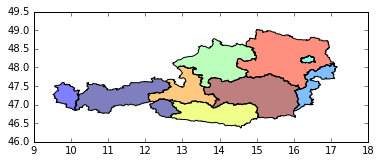

In [45]:
import pandas as pd
import geopandas as gp
%pylab inline
austria_shp = gp.read_file('austria.shp')
austria_shp.plot()
austria = pd.read_csv('austria.csv')
austria.head()

The **Origin** and **Destination** columns refer to the origin, $i$, and destination, $j$, location labels, the **Data** column is the number of flows, the **Oi** and **Dj** columns are the number of total out-flows and total in-flows, respectively, and the **Dij** column is the distance between $i$ and $j$. In this case we use the total out-flow and total in-flow as variables to describe how emissive an origin is and how attractive a destination is. If we want a more informative and interesting model we can replace these with application specific variables that pertain to different hypotheses. Next, lets format the data into arrays.

In [46]:
#make a note of this 
austria = austria[austria['Origin'] != austria['Destination']]
flows = austria['Data'].values
Oi = austria['Oi'].values
Dj = austria['Dj'].values
Dij = austria['Dij'].values
Origin = austria['Origin'].values
Destination = austria['Destination'].values

The Oi and Dj vectors need not be $n^2 \times 1$ vectors. In fact, they can be $n^2 \times k$ where $k$ is the number of variables that are either being used to describe origin or desitnation attributes associated with flows. 

### Calibrating the models

Now, lets load the main SpInt functions and calibrate some models. The main SpInt functions are found within the gravity namespace of the SpInt module and the estimated parameters can be accessed via the **params** attribute of a successfully instantiated spatial interaction model.

In [47]:
from pysal.contrib.spint.gravity import Gravity, Production, Attraction, Doubly

Unconstrained (basic gravity) model

In [51]:
gravity = Gravity(flows, Oi, Dj, Dij, 'exp')
print gravity.params

[ 0.44314667  0.51739961 -0.00979932]


Production-constrained model

In [52]:
production = Production(flows, Origin, Dj, Dij, 'exp')
print production.params[-2:]

[ 0.90285448 -0.0072617 ]


Attraction-constrained model

In [53]:
attraction = Attraction(flows, Destination, Oi, Dij, 'exp')
print attraction.params[-2:]

[ 0.90037216 -0.00695034]


Doubly-constrained model

In [54]:
doubly = Doubly(flows, Origin, Destination, Dij, 'exp')
print doubly.params[-1:]

[-0.00791533]


Note that for the constrained models we have limited the params attribute to print only the main model variables (i.e., not fixed effects), though it is still possible to access the fixed effect parameters too.

In [8]:
print production.params

[-1.16851884  0.52128801  0.98284063 -0.56934181 -0.28515686  0.0381801
 -0.47906115 -0.0141766  -0.1583821   0.90285448 -0.0072617 ]


The first parameter is always the overall intercept with the subsequent 8 parameters representing the fixed effects in this case. You might ask, "why not 9 fixed effects for the 9 different municipalities?". Due to the coding scheme used in SpInt, and many popular statistical programming languages, you would use $n - 1$ binary indicator variables in the design matrix to include the fixed effects for all 9 municipalities in the model. While the non-zero entries in these columns of the design matrix indicate which rows are associated with which miunicipality, where a row has all zero entries then implicitly refers to the $n$th municipality that has been left out. In Spint this is always the first origin or destination for the production-constrained and attraction-constrained models. For the doubly-cosntrained model, both the first origin and the first destination are left out (Tiefelsdorf & Boots, 1995). In terms of interpetting the parameters, these dropped locations are assumed to be 0. Since the fixed effects parameters are interpretted as deviations from the overall intercept. This essentially means the intercept acts as the fixed effect for the first location. Therefore, we could also say first 9 parameters are the origin fixed effect parameters while the last two parameters are for destination attractiveness and distance, respectively. 

### Interpretting the parameters

In [11]:
gravity.params

array([ 0.44314667,  0.51739961, -0.00979932])

In [ ]:
Tij = 

### Assessing model fit

In [57]:

R2 = [gravity.pseudoR2, 
         production.pseudoR2, 
         attraction.pseudoR2, 
         doubly.pseudoR2]

adjR2 = [gravity.adj_pseudoR2, 
         production.adj_pseudoR2, 
         attraction.adj_pseudoR2, 
         doubly.adj_pseudoR2]

SSI = [gravity.SSI, 
       production.SSI, 
       attraction.SSI, 
       doubly.SSI]
SRMSE = [gravity.SRMSE, 
         production.SRMSE,
         attraction.SRMSE,
         doubly.SRMSE]

AIC = [gravity.aic, 
       production.aic, 
       attraction.aic, 
       doubly.aic]

model = ['grav', 'prod', 'att', 'doub']

col_names = ['R2', 'adjR2', 'AIC', 'SRMSE', 'SSI']

cols = {'model': model,
        'R2': R2, 
        'adjR2': adjR2, 
        'SSI': SSI, 
        'SRMSE': SRMSE, 
        'AIC': AIC }

data = pd.DataFrame(cols).set_index('model')
data[col_names]

,R2,adjR2,AIC,SRMSE,SSI
model,,,,,
grav,0.812859,0.812825,32956.747922,1.017571,0.687574
prod,0.910156,0.910031,15841.253799,0.464520,0.740914
att,0.909355,0.909230,15982.313101,0.584048,0.752155
doub,0.943540,0.943335,9977.159141,0.379286,0.811852


From this table we can see all of the fit statistics indicate a better model fit as constraints are introduced. That is, the weakest model fit is consistently related to the gravity model, with similarly increased model fit for the production-constrained and attraction-constrained models, and finally, the best model fit is associated with the doubly constrained model. We can also see that the $R^2$ and adjusted $R^2$ are very close, since these models have a very similar number of explanatory variables, thereby resulting in little to no penalization for model complexity.

We can also take a look at whether the power or exponential distance-decay specification results in a better model fit. For simplicity, lets just take a look at the SRMSE for a doubly constrained model.

In [61]:
print 'SRMSE for exp distance-decay: ', doubly.SRMSE
pow_doubly = Doubly(flows, Origin, Destination, Dij, 'pow')
print 'SRMSE for exp distance-decay: ', pow_doubly.SRMSE

SRMSE for exp distance-decay:  0.37928618533
SRMSE for exp distance-decay:  0.277703139642


For this example, it looks like the power dist-decay specification results in a better model fit.

### Local models

In [66]:
gravity = Gravity(flows, Oi, Dj, Dij, 'pow')
local_gravity = gravity.local(Origin, np.unique(Origin))
print local_gravity['param2']

[-3.4027535985655959, -1.3582517238178298, -0.83072273594370927, -1.1492042884354419, -0.47806696167020846, -1.0094732997391134, -1.6757871751630091, -1.2155693156096277, -1.5396763065983237]


### Testing for overdispersion

## Additional functionality

### Existing features

### Future additions

Finally, there are several paradigms for incorporating spatial effects into spatial interaction models (competing destinations, spatial autoregressive, eigenvector spatial filter)

## References